# QUANTUM BITCOIN AND CHEQUE

## 0. PRELIMINARIES

In [3]:
import math
import qiskit
import matplotlib as plt
from matplotlib import *
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
from scipy.stats import unitary_group

In [4]:
pi=np.pi

In [5]:
def simulate(qc):
    aer_sim = Aer.get_backend('aer_simulator')
    transpiled_qc = transpile(qc, aer_sim)
    qobj = assemble(transpiled_qc)
    results = aer_sim.run(qobj).result()
    counts = results.get_counts()
    return counts

## 1. CLASSICAL HASHING

We start with the theory of Linear Feedback Shift Registers (LFSRs). An LFSR is essentially an algorithm that produces the next state of a system using a linear function of the values of the bits in previous states. Because the operation of the register is deterministic, the stream of values produced by the register is completely determined by its current (or previous) state. Likewise, because the register has a finite number of possible states, it must eventually enter a repeating cycle. However, an LFSR with a well-chosen feedback function can produce a sequence of bits that appears random and has a very long cycle. We will use this property of LFSRs to produce a quantum hashing function that we will crack using the Grover's Algorithm. We will follow the following steps to hash a message. The Grover's Algorithm will then seach for a nonce to append to the message to generate a hash starting with a specific number of zeroes.
Since the SHA-256 essentially uses deterministic linear functions of bits, we can use this LFSR based prototype as a surrogate for the actual SHA-256 in the scarcity of computing resources.

Note that we will use the <b>Little Endian System</b> for our hash register, i.e., the MSB is stored at index $0$ and the LSB at index $n$-1, where $n$ is the number of bits.

The hashing algorithm we use is given below:
<ol>
    <li> Start with an $8$-bit hash register $H=00000000$.</li>
    <li> Read the message from the left, one character at a time.</li>
    <li> Let ASCII of character read be $x$. Perform $H=H\oplus x$.</li>
    <li> Perform $H=\text{LFSR1}(H)$.</li>
    <li> Perform $H=\text{LFSR2}(H)$.</li>
    <li> Repeat steps 3 to 5 for each character read. Return the final hash.</li>
</ol>

In our LFSR, we perform XOR of bits at indices $3$, $4$, $5$, and $7$ and $1$, $2$, $4$, and $7$ respectively. This choice produces a maximal spanning set of hashes with the highest periodicity.
Note that since our process is deterministic, we can easily compute the inverse of the LFSR. However, due to the repaeted XOR operations, it is practically impossible to determine an initial message for a desired hash or achieve a hash collision without brute force.

In [6]:
def LFSR1_Classical(x):
    bit = ((x >> 0) ^ (x >> 2) ^ (x >> 3) ^ (x >> 4)) & 1
    x = ((x >> 1)|(bit<<7))%256;
    return x
def LFSR2_Classical(x):
    bit = ((x >> 0) ^ (x >> 3) ^ (x >> 5) ^ (x >> 6)) & 1
    x = ((x >> 1)|(bit<<7))%256;
    return x
def hash_Classical(message):
    x=0
    for i in message:
        x=x^ord(i)
        x=LFSR1_Classical(x)
        x=LFSR2_Classical(x)
    return x

message=input().rstrip()
print(hash_Classical(message))


0


In [7]:
def LFSRinv1_Classical(x):
    bit = ((x >> 1) ^ (x >> 2) ^ (x >> 3) ^ (x >> 7)) & 1
    x = ((x << 1)|bit)%256;
    return x

In [8]:
def LFSR2_Classical(x):
    bit = ((x >> 0) ^ (x >> 3) ^ (x >> 5) ^ (x >> 6)) & 1
    x = ((x >> 1)|(bit<<7))%256;
    return x

In [9]:
def LFSRinv2_Classical(x):
    bit = ((x >> 2) ^ (x >> 4) ^ (x >> 5) ^ (x >> 7)) & 1
    x = ((x << 1)|bit)%256;
    return x

In [10]:
def hash_Classical(message):
    x=0
    for i in message:
        x=x^ord(i)
        x=LFSR1_Classical(x)
        x=LFSR2_Classical(x)
    return x

In [61]:
message='Hello World'

## 2. QUANTUM HASHING

In this section, we will apply a quantum algorithm to perform the hashing defined above.

Note that here too we will use the <b>Little Endian System</b> for our hash register, i.e., the MSB is stored at index $0$ and the LSB at index $n$-1, where $n$ is the number of bits.

We will use two 8-qubit registers, the first register to store a character in its Little Endian ASCII form and the second register to compute and store the hash.

The XOR operations are performed using CX gates. The shifts in LFSRs are performed using 2-qubit swap gates. The circuit diagram for the LFSR and its inverse is presented below.

### 2.1. Quantum LFSR

In [12]:
def LFSR1_Quantum():    
    qc = QuantumCircuit(8)
    for qubit in range(7,0,-1):
        qc.swap(qubit-1,qubit)
    qc.cx(6,0)
    qc.cx(5,0)
    qc.cx(4,0)
    lfsr=qc.to_gate()
    lfsr.name = r"$LFSR1$"
    return qc,lfsr

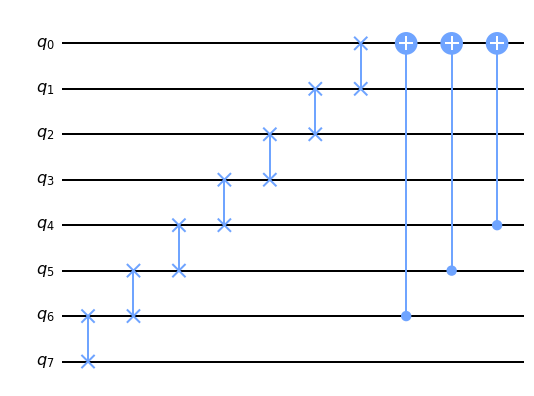

In [13]:
LFSR1_Quantum()[0].draw('mpl')

In [14]:
def LFSR2_Quantum():    
    qc = QuantumCircuit(8)
    for qubit in range(7,0,-1):
        qc.swap(qubit-1,qubit)
    qc.cx(5,0)
    qc.cx(3,0)
    qc.cx(2,0)
    lfsr=qc.to_gate()
    lfsr.name = r"$LFSR2$"
    return qc,lfsr

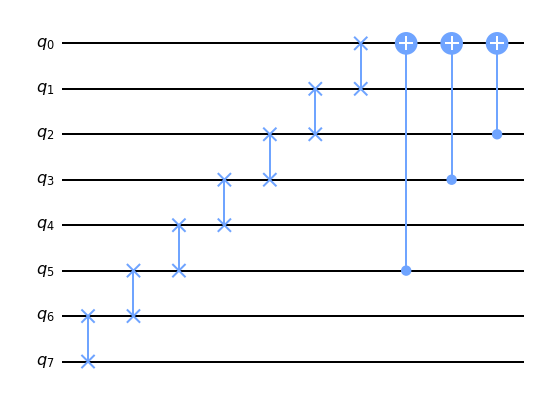

In [15]:
LFSR2_Quantum()[0].draw('mpl')

### 2.2. Inverse of the Quantum LFSR

In [16]:
def LFSRinv1_Quantum():    
    qc = QuantumCircuit(8)
    for qubit in range(1,8):
        qc.swap(qubit-1,qubit)
    qc.cx(3,7)
    qc.cx(4,7)
    qc.cx(5,7)
    lfsr=qc.to_gate()
    lfsr.name = r"$LFSR1^{-1}$"
    return qc,lfsr

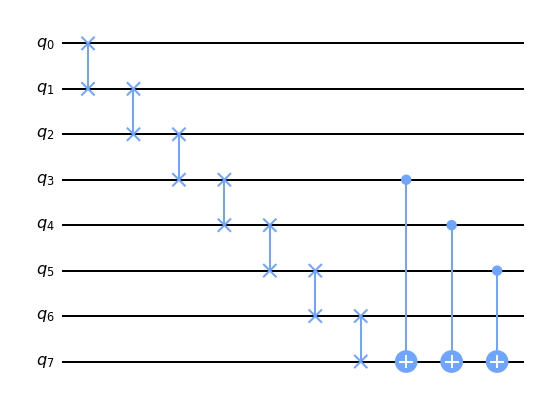

In [17]:
LFSRinv1_Quantum()[0].draw('mpl')

In [18]:
def LFSRinv2_Quantum():    
    qc = QuantumCircuit(8)
    for qubit in range(1,8):
        qc.swap(qubit-1,qubit)
    qc.cx(1,7)
    qc.cx(2,7)
    qc.cx(4,7)
    lfsr=qc.to_gate()
    lfsr.name = r"$LFSR2^{-1}$"
    return qc,lfsr

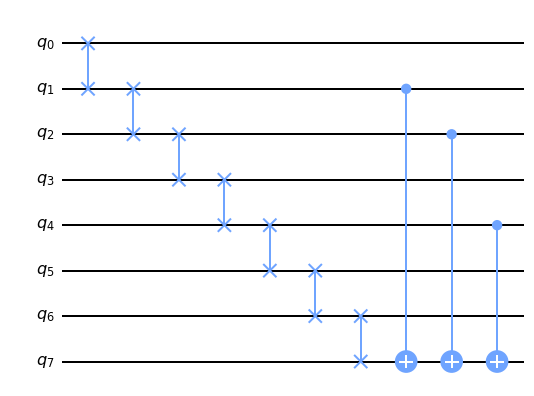

In [19]:
LFSRinv2_Quantum()[0].draw('mpl')

### 2.3. The Oracle

We will use an extra qubit for the output. This qubit will store 1 conditionally when the starting qubits of the register are zero.

The oracle is the set of operations that are performed on the quantum state to produce the output conditionally by flipping the sign if it the input meets our conditions, else keeping it as it is.

In [20]:
def oracle(qc, nonce, register):
    for i in range(8):
        qc.cx(nonce[i],register[i])
    qc.append(LFSR1_Quantum()[1], register)
    qc.append(LFSR2_Quantum()[1], register)
    for i in range(5):
        qc.x(register[i])
    qc.mct(register[0:5], output)
    for i in range(5):
        qc.x(register[i])
    qc.append(LFSRinv2_Quantum()[1], register)
    qc.append(LFSRinv1_Quantum()[1], register)
    for i in range(8):
        qc.cx(nonce[i],register[i])

## 3. GROVER AND GENERALIZED GROVER SEARCH FOR NONCE

The standard Grover Search diffuser.

In [39]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = r"$U_s$"
    return qc,U_s

## 3.1. Generalized Grover Diffuser

We replace the combination of the $X$ and $H$ gates using $R_y(\frac{\pi}{2})$ gates. This reduces a total of $16$ gates per iteration.

In [30]:
def gen_diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.ry(pi/2,qubit)
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.ry(-pi/2,qubit)
    U_g = qc.to_gate()
    U_g.name = r"$U_g$"
    return qc,U_g

## 4.  FINAL CIRCUIT

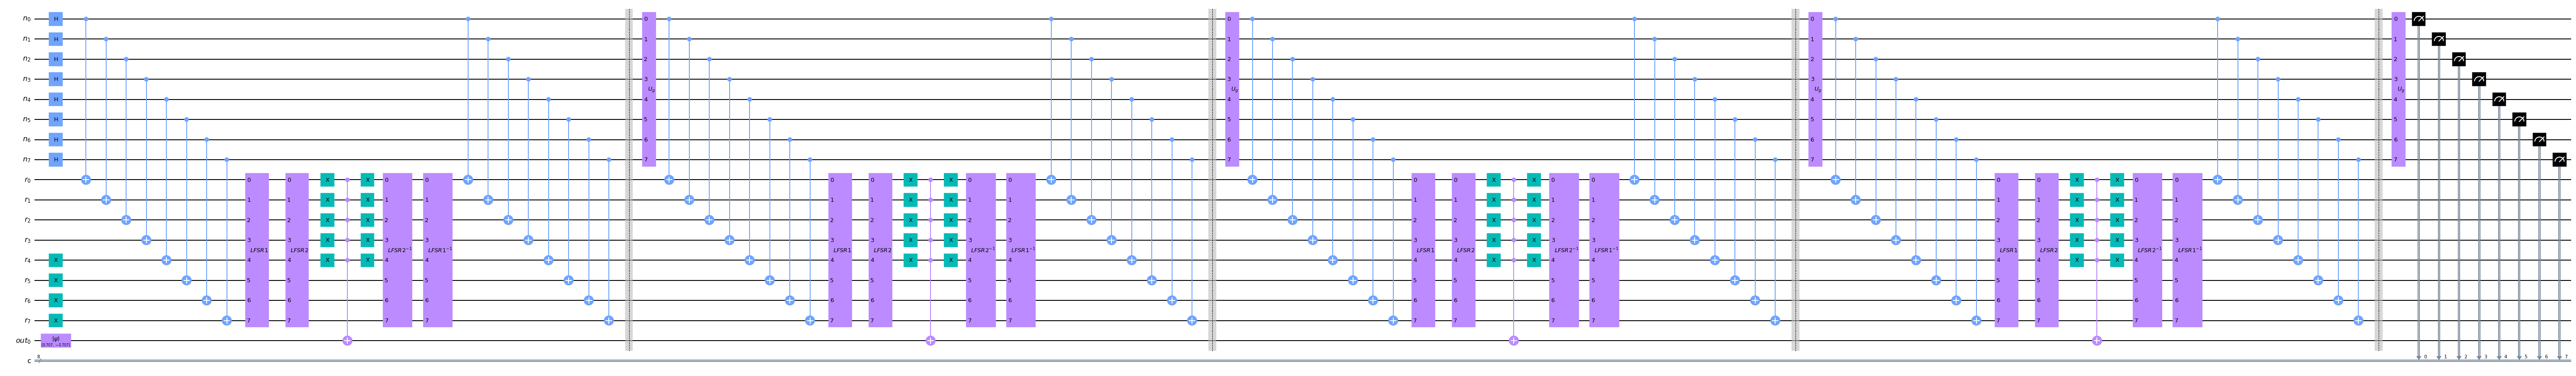

In [62]:
nonce = QuantumRegister(8, name='n')
register = QuantumRegister(8, name='r')
output = QuantumRegister(1, name='out')
cbits=ClassicalRegister(8, name='c')
qc = QuantumCircuit(nonce,register,output,cbits)

qc.initialize([1, -1]/np.sqrt(2), output)
i=7
classical_hash=hash_Classical(message)
while(classical_hash!=0):
    if classical_hash&1: 
        qc.x(register[i])
    i-=1
    classical_hash=classical_hash>>1
#qc.measure(register,cbits)
qc.h(nonce)

for _ in range(4):
    oracle(qc, nonce, register)
    qc.barrier()
    qc.append(gen_diffuser(8)[1], [0,1,2,3,4,5,6,7])


qc.measure(nonce,cbits)
qc.draw('mpl',fold=-1)

In [63]:
l=simulate(qc)

In [64]:
l

{'00111000': 132,
 '11000000': 130,
 '10101000': 133,
 '10011000': 115,
 '11110000': 146,
 '01100000': 130,
 '01010000': 121,
 '00001000': 117}

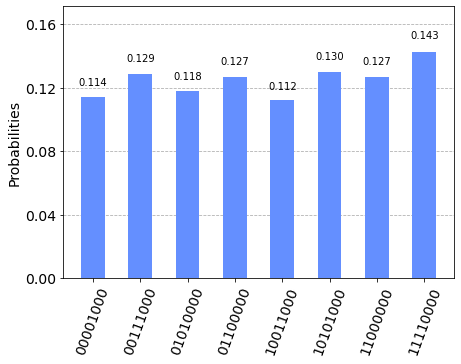

In [65]:
plot_histogram(l)

In [66]:
nonce_values=list()
for i in l.keys():
    if l[i]>30:
        nonce_val=int(i[::-1],2)
        nonce_values.append(nonce_val)
nonce_values

[28, 3, 21, 25, 15, 6, 10, 16]

In [69]:
[chr(x) for x in nonce_values]

['\x1c', '\x03', '\x15', '\x19', '\x0f', '\x06', '\n', '\x10']

In [67]:
for i in nonce_values:
    message_new=message+chr(i)
    print(hash_Classical(message_new))

4
3
6
5
0
2
1
7


In [2]:
def initialize():    
    qc = QuantumCircuit(8)
    init=qc.to_gate()
    init.name = 'init'
    return qc,init

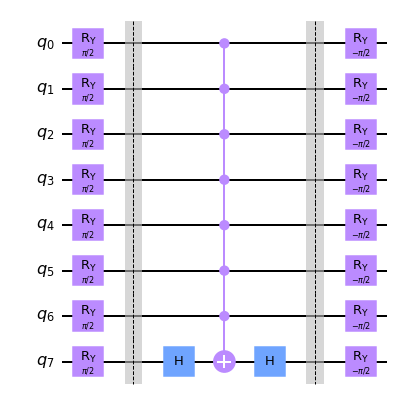

In [37]:
nqubits=8
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.ry(pi/2,qubit)
qc.barrier()
qc.h(nqubits-1)
qc.mct(list(range(nqubits-1)), nqubits-1)
qc.h(nqubits-1)
qc.barrier()
for qubit in range(nqubits):
    qc.ry(-pi/2,qubit)
qc.draw('mpl')

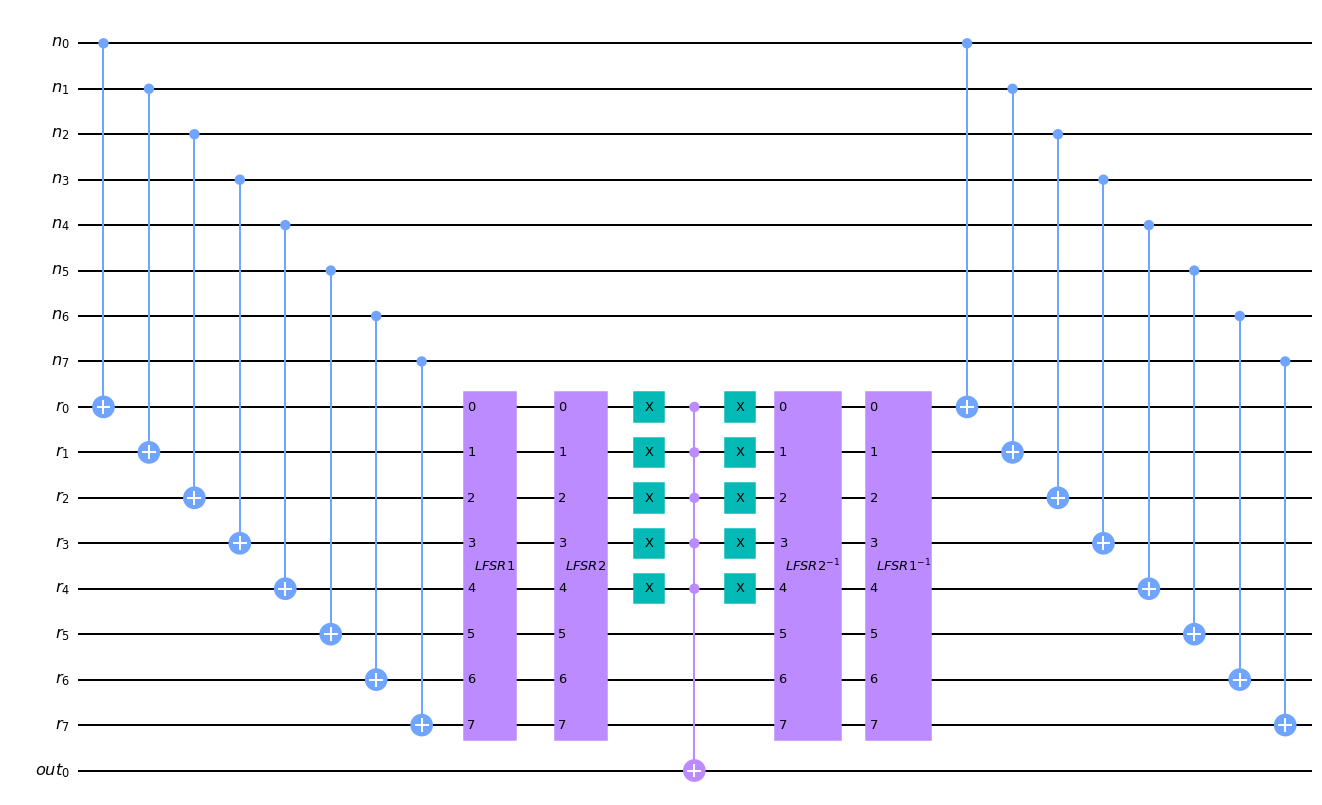

In [28]:
nonce = QuantumRegister(8, name='n')
register = QuantumRegister(8, name='r')
output = QuantumRegister(1, name='out')
qc = QuantumCircuit(nonce,register,output)
oracle(qc, nonce, register)
qc.draw('mpl',fold=-1)